In [1]:
import gensim
from gensim.models.callbacks import LossLogger, LossSetter
from gensim.models.keyedvectors import PoincareWordEmbeddingsKeyedVectors as pkv
from gensim.matutils import argsort
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot
import os
import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import random
from scipy import stats
random.seed(42)

# plotly.tools.set_credentials_file(username='alex-tifrea', api_key='MTEfiBZpFVHiVr9AZcvW')
init_notebook_mode(connected=True)
ROOT = "/Users/alext/Documents/Master/Thesis/"

# Evolution of vector norms during training for Poincare Embeddings

In [2]:
# train_log = os.path.join(ROOT, 
#                          "train_logs/train_levy_nll_3_100_A05_a001_n5_w5_c100_poincare_OPTwfullrsgd_bias_burnin1")
train_log = os.path.join(ROOT, 
                         "train_logs/train_levy_nll_5_100_A01_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMcosh-dist-sq_burnin1")
buckets = []

NUM_OF_BURNIN_EPOCHS = 1

def get_data_from_line(line):
    line = line.split(":")
    epoch = int(line[0].split(" ")[2])
    if epoch > NUM_OF_BURNIN_EPOCHS:
        epoch = epoch - 1
    target_emb_norm = float(line[2].split(" ")[1])
    context_emb_norm = float(line[2].split(" ")[3])
    return [epoch, target_emb_norm, context_emb_norm]

with open(train_log, "r") as f:
    content = [line.strip() for line in f.readlines()]
    
    # Get buckets.
    initial_data = list(filter(lambda l: "EPOCH - 0 : Average target and context vector norm" in l, content))
    buckets = [int(l.split(" ")[13]) for l in initial_data]
    print("Buckets:")
    print(buckets)
    
    bucket_data = []
    for thresh in buckets:
        data = list(filter(
            lambda l: "{} words".format(thresh) in l and "EPOCH - {}".format(NUM_OF_BURNIN_EPOCHS) not in l, 
            content))
        bucket_data += [np.array([get_data_from_line(l) for i, l in enumerate(data)])]
    
# Plot target vector avg Euclidean norm VS context vector avg Euclidean norm for top 10 words
w10 = bucket_data[0]
l1 = go.Scatter(
    x=w10[:, 0],
    y=w10[:, 1],
    mode="lines+markers",
    name='Target vectors average Euclidean norm')
l2 = go.Scatter(
    x=w10[:, 0],
    y=w10[:, 2],
    mode="lines+markers",
    name='Context vectors average Euclidean norm')

layout = dict(
    title = 'Target vector avg Euclidean norm vs Context vector avg Euclidean norm for the top 10 words',
    xaxis = dict(title = 'Epoch'),
    yaxis = dict(title = 'Vector Euclidean norm'),
)
iplot(dict(data=[l1, l2], layout=layout))

Buckets:
[10, 100, 500, 1000, 5000, 10000, 50000, 100000]


In [3]:
fig = tools.make_subplots(rows=2, cols=1, 
                          subplot_titles=('Target vector avg Euclidean norms', 'Context vector avg Euclidean norms'))
for i, b in enumerate(buckets):
    norms = bucket_data[i]
    fig.append_trace(
        go.Scatter(
            x=norms[:, 0],
            y=norms[:, 1],
            mode="lines+markers",
            name="Top {} words".format(b)), 1, 1)

context_lines = []
for i, b in enumerate(buckets):
    norms = bucket_data[i]
    fig.append_trace(
        go.Scatter(
            x=norms[:, 0],
            y=norms[:, 2],
            mode="lines+markers",
            name="Top {} words".format(b)), 2, 1)

fig['layout']['xaxis1'].update(title='Epoch')
fig['layout']['xaxis2'].update(title='Epoch')
fig['layout']['yaxis1'].update(title='Vector Euclidean norm')
fig['layout']['yaxis2'].update(title='Vector Euclidean norm')

fig['layout'].update(height=1000, width=900)

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



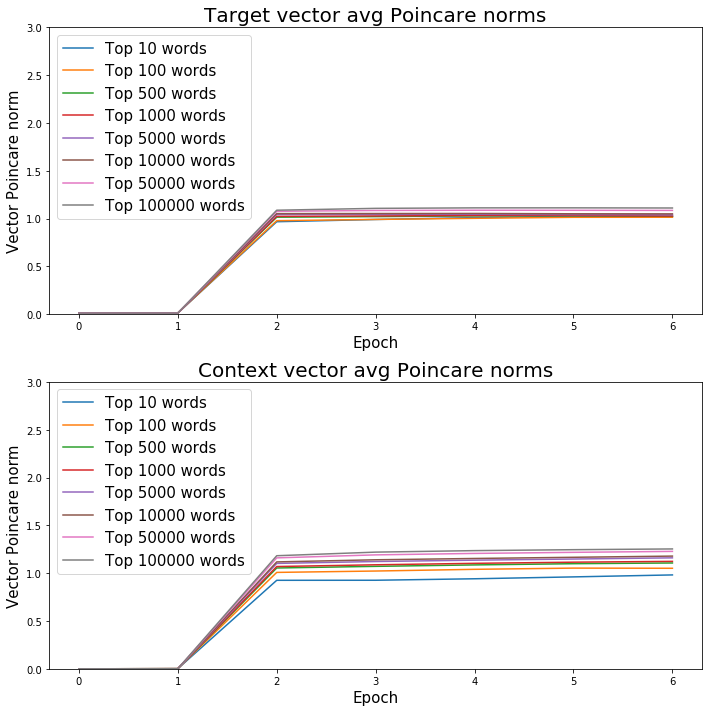

In [4]:
def euclidean_norm2poincare_norm(e_norm):
    return np.arccosh(1 + 2 * e_norm*e_norm / (1 - e_norm * e_norm))

fig = plt.figure(figsize=(10, 10))

labels = []
label_names = []

# Plot target vector avg Poincare norm for all buckets
plt.subplot(211)
for i, b in enumerate(buckets):
    norms = bucket_data[i]
    label, = plt.plot(norms[:, 0], euclidean_norm2poincare_norm(norms[:, 1]))
    labels.append(label)
    label_names.append("Top {} words".format(b))
plt.legend(labels, label_names, fontsize=15, loc='upper left')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Vector Poincare norm', fontsize=15)
plt.xticks(range(len(bucket_data[0]))[:])
plt.ylim([0, 3])
_ = plt.title("Target vector avg Poincare norms", fontsize=20) 

# Plot context vector avg Poincare norm for all buckets
plt.subplot(212)
labels = []
label_names = []
for i, b in enumerate(buckets):
    norms = bucket_data[i]
    label, = plt.plot(norms[:, 0], euclidean_norm2poincare_norm(norms[:, 2]))
    labels.append(label)
    label_names.append("Top {} words".format(b))
plt.legend(labels, label_names, fontsize=15, loc='upper left')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Vector Poincare norm', fontsize=15)
plt.xticks(range(len(bucket_data[0]))[:])
plt.ylim([0, 3])
_ = plt.title("Context vector avg Poincare norms", fontsize=20) 

fig.tight_layout()

## Check if parallel transport is invariant to gyrovector gyrotranslation

In [2]:
hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A01_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMcosh-dist-sq_burnin1")
hyp_model = gensim.models.Word2Vec.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [3]:
def my_gyr(u, v, x):
    return pkv.gyr_mat(u.reshape(1, -1), v.reshape(1, -1), x.reshape(1, -1)).reshape(-1,)
curr_gyr = my_gyr

def get_parallel_transport1(a, b, c):
    gyr_result = curr_gyr(c, -a, pkv.moebius_add(-a, b))
    return pkv.moebius_add(c, gyr_result)

z = hyp_wv["translate"]

a = hyp_wv["king"]
b = hyp_wv["queen"]
c = hyp_wv["man"]

pt = get_parallel_transport1(a, b, c)
z_pt = pkv.moebius_add(z, pt)
translated_pt = get_parallel_transport1(
        pkv.moebius_add(z, a),
        pkv.moebius_add(z, b),
        pkv.moebius_add(z, c))
print("Check if gyr preserves the norm:", norm(pkv.moebius_add(-a, b)), norm(curr_gyr(c, -a, pkv.moebius_add(-a, b))))
print("Check if translation preserves parallel transport:", norm(z_pt - translated_pt))

Check if gyr preserves the norm: 0.398895034406031 0.398895034406031
Check if translation preserves parallel transport: 2.122675856677594e-16


# Correlation between norm and word frequency

In [2]:
w2v_model_fn = os.path.join(ROOT, "models/word2vec_baseline/w2v_levy_sg_5_100_A025_a0001_n5_w5_c100_cosine_OPTsgd")
w2v_model = gensim.models.Word2Vec.load(w2v_model_fn)
w2v_wv = w2v_model.wv

In [3]:
euclid_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_sg_5_600_A025_a0001_n5_w5_c100_euclid_bias")
euclid_model = gensim.models.Word2Vec.load(euclid_model_fn)
euclid_wv = euclid_model.wv

In [4]:
# hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A01_a01_n5_w5_c100_poincare_OPTwfullrsgd_burnin3")
hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A01_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMcosh-dist-sq_burnin1")
hyp_model = gensim.models.Word2Vec.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [10]:
restrict_vocab = range(len(w2v_wv.index2word))[10000:]
word_freq = np.array([w2v_wv.vocab[word].count for word in w2v_wv.index2word])[restrict_vocab]
w2v_vector_norms = norm(w2v_wv.vectors, axis=1)[restrict_vocab]
euclid_vector_norms = norm(euclid_wv.vectors, axis=1)[restrict_vocab]
hyp_target_vector_norms = norm(hyp_wv.vectors, axis=1)[restrict_vocab]
hyp_context_vector_norms = norm(hyp_model.trainables.syn1neg, axis=1)[restrict_vocab]
# hyp_biases = hyp_bias = hyp_model.trainables.b1[:restrict_vocab]

print("Spearman correlation between Word2Vec vector norms and word frequency:", 
      stats.spearmanr(1.0/word_freq, w2v_vector_norms)[0])
print("Spearman correlation between Euclidean-distance vector norms and word frequency:", 
      stats.spearmanr(1.0/word_freq, euclid_vector_norms)[0])
print("Spearman correlation between Poincare target vector norms and word frequency:", 
      stats.spearmanr(1.0/word_freq, hyp_target_vector_norms)[0])
print("Spearman correlation between Poincare context vector norms and word frequency:", 
      stats.spearmanr(1.0/word_freq, hyp_context_vector_norms)[0])
# print("Spearman correlation between Poincare biases and word frequency:", 
#       stats.spearmanr(word_freq, hyp_biases)[0])

print(stats.spearmanr(hyp_target_vector_norms, hyp_context_vector_norms)[0])

Spearman correlation between Word2Vec vector norms and word frequency: 0.023935047086462526
Spearman correlation between Euclidean-distance vector norms and word frequency: -0.9003140890838771
Spearman correlation between Poincare target vector norms and word frequency: 0.39952760564392803
Spearman correlation between Poincare context vector norms and word frequency: 0.3016783682828685
0.8567969671300832


## Vector norms (dot product model vs Euclidean model w/ biases)

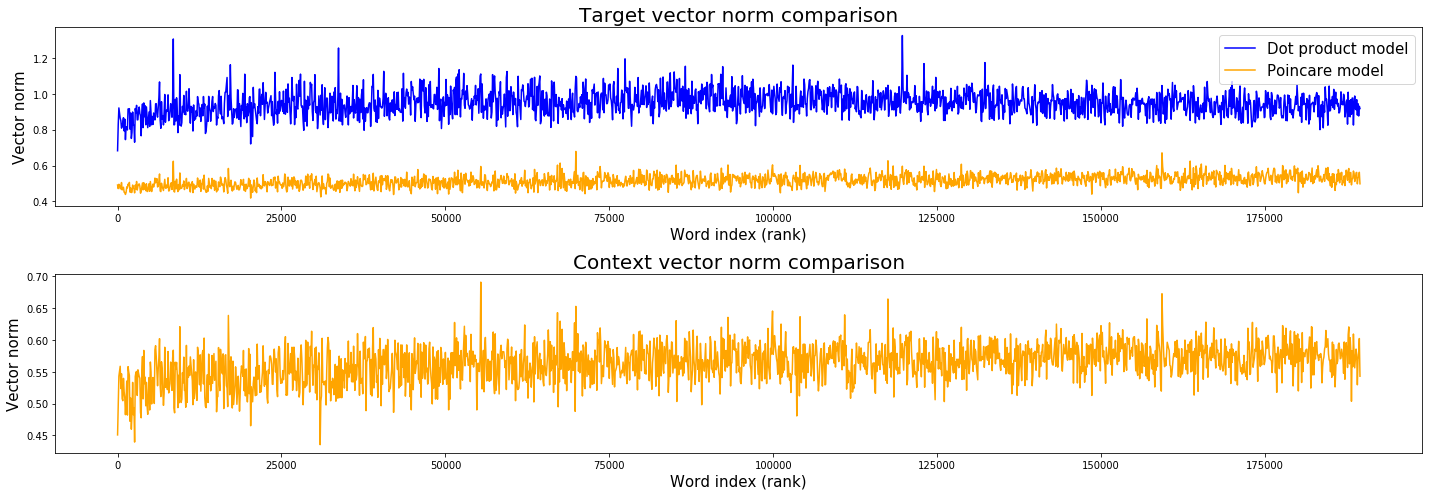

In [39]:
restrict_vocab = 10000

# Plot target vector norms.
fig = plt.figure(figsize=(20, 7))
x = range(len(hyp_wv.index2entity))
dotprod_norms = [norm(w2v_wv.word_vec(w)) for w in w2v_wv.index2entity]
hyp_norms = [norm(hyp_wv.word_vec(w)) for w in hyp_wv.index2entity]

plt.subplot(211)
l1, = plt.plot(x[::100], np.sqrt(dotprod_norms[::100]) / 2, color="blue")
l2, = plt.plot(x[::100], hyp_norms[::100], color="orange")
plt.legend([l1, l2], ["Dot product model", "Poincare model"], fontsize=15)
plt.ylabel("Vector norm", fontsize=15)
plt.xlabel("Word index (rank)", fontsize=15)
_ = plt.title("Target vector norm comparison", fontsize=20)


# Plot target vector norms.
dotprod_norms = [norm(w2v_model.trainables.syn1neg[idx]) for idx in x]
hyp_norms = [norm(hyp_model.trainables.syn1neg[idx]) for idx in x]

plt.subplot(212)
# l1, = plt.plot(x[::100], dotprod_norms[::100], color="blue")
l2, = plt.plot(x[::100], hyp_norms[::100], color="orange")
# plt.legend([l1, l2], ["Dot product model", "Poincare model"], fontsize=15)
plt.ylabel("Vector norm", fontsize=15)
plt.xlabel("Word index (rank)", fontsize=15)
_ = plt.title("Context vector norm comparison", fontsize=20)

fig.tight_layout()

# Embedding norm w/ and w/o biases

In [107]:
x = range(len(hyp_wv.index2entity))
o = np.zeros(hyp_model.vector_size, dtype=np.float32)
# restrict_vocab = 10000

target_norms = np.array([norm(hyp_wv.word_vec(w)) for w in hyp_wv.index2entity])
context_norms = np.array([norm(hyp_model.trainables.syn1neg[idx]) for idx in range(len(hyp_wv.index2entity))])
poincare_target_norms = np.array([hyp_wv.embedding_norm(w) for w in hyp_wv.index2word])
poincare_context_norms = np.array([hyp_wv.embedding_norm(hyp_model.trainables.syn1neg[idx]) for idx in range(len(hyp_wv.index2word))])
b1 = hyp_model.trainables.b1

fig = plt.figure(figsize=(20, 11))
# Plot Euclidean norms for model
plt.subplot(221)
l1, = plt.plot(x[::100], target_norms[::100], color="green")
l2, = plt.plot(x[::100], context_norms[::100], color="orange")
plt.legend([l1, l2], ["Target", "Context"], fontsize=15, loc="lower right")
plt.ylabel("Vector Euclidean norm", fontsize=15)
plt.xlabel("Word index (rank)", fontsize=15)
_ = plt.title("Vector Euclidean norms", fontsize=20)

# Plot Poincare norms for model
plt.subplot(222)
l1, = plt.plot(x[::100], poincare_target_norms[::100], color="green")
l2, = plt.plot(x[::100], poincare_context_norms[::100], color="orange")
plt.legend([l1, l2], ["Target", "Context"], fontsize=15, loc="lower right")
plt.ylabel("Vector Poincare norm", fontsize=15)
plt.xlabel("Word index (rank)", fontsize=15)
_ = plt.title("Vector Poincare norms", fontsize=20)

def pow_law(x):
    # y = a * x^k + eps
    a = 10
    k = -0.09
    eps = -4.4
    return a * np.power(np.array(x).astype(np.float32), k) + eps

# Plot biases
plt.subplot(224)
l1, = plt.plot(list(x[:100]) + list(x[::100]), list(b1[:100]) + list(b1[::100]), color="red")
l2, = plt.plot(list(x[10:100]) + list(x[::100]), pow_law(np.array(list(x[10:100]) + list(x[::100]))), color="blue")
# l3, = plt.plot(x[::100], np.power(((np.array(b1[::100]) + 4.4) / 10), -11.11), color="green")
# plt.legend([l1], ["Biases"], fontsize=15)
plt.ylabel("Bias", fontsize=15)
plt.xlabel("Word index (rank)", fontsize=15)
_ = plt.title("Biases", fontsize=20)

fig.tight_layout()

AttributeError: 'Word2VecTrainables' object has no attribute 'b1'

#### Vector norm analysis

In [29]:
w2v_model_fn = os.path.join(ROOT, "models/word2vec_baseline/w2v_levy_sg_5_100_A025_a0001_n5_w5_c100_cosine_OPTsgd")
w2v_model = gensim.models.Word2Vec.load(w2v_model_fn)
w2v_wv = w2v_model.wv

In [30]:
hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A01_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMcosh-dist-sq_burnin1")
# hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A01_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMcosh-dist-sq_burnin1_neg-sampl-power1.0")
# hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A05_a001_n5_w5_c100_poincare_OPTwfullrsgd_bias_burnin1")
# hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A01_a01_n5_w5_c100_poincare_OPTwfullrsgd_burnin3")
hyp_model = gensim.models.Word2Vec.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [31]:
# hyp2d_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_2_100_A05_a001_n5_w5_c100_poincare_OPTwfullrsgd_bias_burnin1")
# hyp2d_model = gensim.models.Word2Vec.load(hyp2d_model_fn)
# hyp2d_wv = hyp2d_model.wv

hyp_norms = np.linalg.norm(hyp_wv.vectors, axis=1)
print("Average vector mean:", np.average(hyp_norms), "; Stddev norms =", np.std(hyp_norms), "; Min norm =", 
      np.min(hyp_norms), "; Max norm =", np.max(hyp_norms))

Average vector mean: 0.5161375270951657 ; Stddev norms = 0.03339733987350289 ; Min norm = 0.33435073999996273 ; Max norm = 0.8109192863273453


In [32]:
# model2d_fn = os.path.join(ROOT, "models/word2vec_baseline/w2v_levy_sg_5_2_A025_a0001_n5_w5_c25000_cosine_OPTsgd")
# model2d = gensim.models.Word2Vec.load(model2d_fn)
# wv2d = model2d.wv
# wv2d.init_sims(replace=True)

w2v_norms = np.linalg.norm(w2v_wv.vectors, axis=1)
print("Average vector norm:", np.average(w2v_norms), "; Stddev norms =", np.std(w2v_norms), "; Min norm =", 
      np.min(w2v_norms), "; Max norm =", np.max(w2v_norms))

Average vector norm: 3.622724 ; Stddev norms = 0.5218608 ; Min norm = 1.4649142 ; Max norm = 11.353996


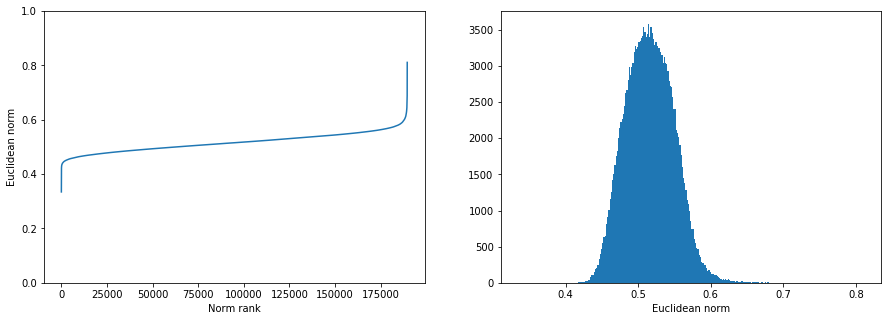

In [40]:
lim = list(range(len(hyp_norms)))[:]
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(np.array(range(len(hyp_norms)))[lim], np.array(sorted(hyp_norms))[lim]) 
plt.ylim([0, 1])
plt.xlabel("Norm rank")
plt.ylabel("Euclidean norm")
plt.subplot(122)
plt.hist(hyp_norms, bins="auto")
_ = plt.xlabel("Euclidean norm")

## Nearest neighbors

#### Compute Relative Contrast of a model

In [25]:
w2v_model_fn = os.path.join(ROOT, "models/word2vec_baseline/w2v_levy_sg_5_100_A025_a0001_n5_w5_c100_cosine_OPTsgd")
w2v_model = gensim.models.Word2Vec.load(w2v_model_fn)
w2v_wv = w2v_model.wv

In [26]:
hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A01_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMcosh-dist-sq_burnin1")
# hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_5_100_A05_a001_n5_w5_c100_poincare_OPTwfullrsgd_bias_burnin1")
# hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_3_2_A005_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMlog-dist-sq_burnin1")
# hyp_model_fn = os.path.join(ROOT, "models/geometric_emb/w2v_levy_nll_3_2_A001_a0001_n5_w5_c100_poincare_OPTwfullrsgd_SIMlog-dist-sq_burnin1")
hyp_model = gensim.models.Word2Vec.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [27]:
restrict_vocab=500000
def compute_relative_contrast(index, wv):
    limited = np.delete(wv.vectors[:restrict_vocab], index, 0)
    dists = wv.distances(wv.vectors[index], limited)
    min_dist = np.min(dists)
    mean_dist = np.average(dists)
    return mean_dist / (min_dist + 1e-15)

def compute_avg_relative_contrast(wv, num_queries=100):
    indexes = random.sample(range(100), num_queries) + random.sample(range(100, min(restrict_vocab, len(wv.vocab))), num_queries)
    rcs = []
    for idx in indexes:
        rcs.append(compute_relative_contrast(idx, wv))
    
#     print(list(zip(indexes, rcs)))

    print("Average Relative Contrast (top 100 words):", np.average(np.array(rcs[:num_queries])))
    print("Average Relative Contrast (rest of the words):", np.average(np.array(rcs[num_queries:])))
    print("Average Relative Contrast:", np.average(np.array(rcs)))

In [28]:
compute_avg_relative_contrast(wv=hyp_wv, num_queries=100)

Average Relative Contrast (top 100 words): 1.507716112750484
Average Relative Contrast (rest of the words): 1.5765553739710263
Average Relative Contrast: 1.5421357433607552


In [29]:
compute_avg_relative_contrast(wv=w2v_wv, num_queries=100)

Average Relative Contrast (top 100 words): 4.003072801060318
Average Relative Contrast (rest of the words): 5.525359920296844
Average Relative Contrast: 4.7642163606785815


In [11]:
compute_avg_relative_contrast(wv=hyp2d_wv, num_queries=50)

NameError: name 'hyp2d_wv' is not defined

In [20]:
compute_avg_relative_contrast(wv=wv2d, num_queries=50)

Average Relative Contrast (top 100 words): 36745310669090.84
Average Relative Contrast (last words): 22922921086822.605
Average Relative Contrast: 29834115877956.73


#### Relative contrast analysis (looking at the distance distribution for the neighbors of a word)

[word2vec] Target word "color": 104004 8.303594446650292
	Avg: 0.8500936 ; stddev: 0.111826174 ; min: 0.10237658 ; max: 1.222714
[poincare] Target word "color": 104004 1.6462829004115596
	Avg: 1.78787245016613 ; stddev: 0.14568825313620234 ; min: 1.0860056006893908 ; max: 4.695325906283731


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



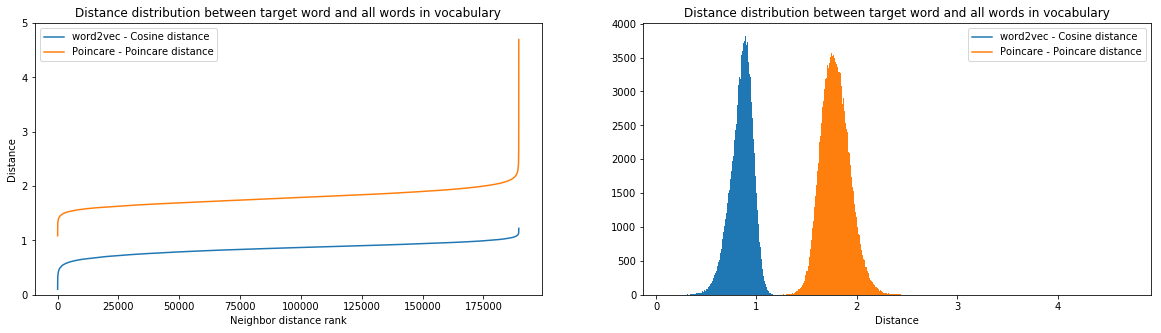

In [12]:
fig = plt.figure(figsize=(20, 5))
def analyze_nearest_neighbors(wv, emb_type):
    restrict_vocab = 500000
    word = "color"
    index = wv.vocab[word].index
    print("["+emb_type+"] Target word \""+word+"\":", wv.vocab[word].count, compute_relative_contrast(index, wv))
    limited = np.delete(wv.vectors[:restrict_vocab], index, 0)
    dists = wv.distances(wv.vectors[index], limited).reshape(-1,)

    print("\tAvg:", np.average(dists), "; stddev:", np.std(dists), "; min:", np.min(dists), "; max:", np.max(dists))

    plt.subplot(121)
    plot_num=2000
    l, = plt.plot(list(range(len(limited))), sorted(dists))
    
    plt.subplot(122)
    plt.hist(dists, bins="auto")

    return l, go.Scatter(
        x=list(range(len(limited)))[:plot_num],
        y=sorted(dists)[:plot_num],
        mode="lines+markers",
        name=emb_type)
    
l1, t1 = analyze_nearest_neighbors(w2v_wv, "word2vec")
l2, t2 = analyze_nearest_neighbors(hyp_wv, "poincare")

iplot(dict(data=[t1, t2]))

plt.subplot(121)
plt.legend([l1, l2], ["word2vec - Cosine distance", "Poincare - Poincare distance"])
plt.ylim((0, 5))
plt.xlabel("Neighbor distance rank")
plt.ylabel("Distance")
plt.title("Distance distribution between target word and all words in vocabulary")

plt.subplot(122)
plt.legend([l1, l2], ["word2vec - Cosine distance", "Poincare - Poincare distance"])
plt.xlabel("Distance")
_ = plt.title("Distance distribution between target word and all words in vocabulary")


#### Nearest neighbors queries

In [17]:
def cosine_distance(vector, other_vectors):
    return 1 - gensim.models.keyedvectors.VanillaWordEmbeddingsKeyedVectors.cosine_similarities(
        vector, other_vectors)

def gyrocosine_distance(vector, other_vectors):
    other_vectors_norm = other_vectors / (pkv.embedding_norms_mat(other_vectors)[:, None] + 1e-10)
    vector_norm = vector / (hyp_wv.embedding_norm(word_or_vector=vector) + 1e-10)
    return 1 - (other_vectors_norm * vector_norm).sum(axis=1)

def poincare_distance(vector, other_vectors):
    diff = other_vectors - vector
    alpha_v = 1.0 / (1 - np.dot(vector, vector))
    beta_w = 1.0 / (1 - (other_vectors * other_vectors).sum(axis=1))
    return np.arccosh(1 + 2 * (diff * diff).sum(axis=1) * alpha_v * beta_w)

def get_knn(query, distance, curr_wv, k=10, restrict_vocab=200000):
    index = curr_wv.vocab[query].index
    limited = curr_wv.vectors[:restrict_vocab]
    dists = distance(curr_wv.vectors[index], limited)
    knn_indexes = gensim.matutils.argsort(dists, topn=k)
    return list(zip([curr_wv.index2word[idx] for idx in knn_indexes], 
                    np.around(dists[knn_indexes], decimals=3), 
                    [norm(hyp_wv.vectors[idx]) for idx in knn_indexes]))
#     return [curr_wv.index2word[idx] for idx in knn_indexes]


#### Vectors that are closest to the center of the ball

In [23]:
norms = list(zip(range(len(hyp_wv.vectors)), norm(hyp_wv.vectors, axis=1)))
norms = sorted(norms, key=lambda x: x[1])
# print([(hyp_wv.index2word[idx], curr_norm) for idx, curr_norm in norms[:100]])
print([hyp_wv.index2word[idx] for idx, curr_norm in norms[-100:]])

['muricidae', 'boulgou', 'mordellistena', 'grandpafootsoldier', 'rhein-lahn', 'retiredfederalist', 'bhedam', 'gmina', 'non-swiss', 'marginellidae', 'gnagna', 'ganzourgou', 'cerithiopsidae', 'jura-nord', 'haargis', 'carabinae', 'schilderessen', 'omegatiming', 'reduced-price', 'ulidiid', "upazila's", 'stenalia', 'orthogoniinae', 'hiwish', 'fissurellidae', 'petuchah', 'emmalocera', 'a-international', 'ammonian', 'miridae', 'gymnobela', 'solariellidae', 're-electiondemocratic-republican', 'colloniidae', 'lottiidae', 'mordella', 'us-k', 'wohnungen', 'acaridae', 'tenebrionoidea', 'ancylosis', 'splendrillia', 'dehestan', 'fasciolariidae', 'pyramidellidae', 'bazga', 'bevlkerungsdaten', 'constituencya', 'pre-county', 'lohko', 'olethreutinae', 'candidating', 'xinglong', 'african-eurasian', 'columbellidae', 'military_equipment_by_type', 'raphitomidae', 'reportsbelow', 'banmauk', 'tortricinae', 'tomoxia', 'hydro-lyase', 'military_equipment', 'nebriinae', 'ds-p1-yu', 'kommunalreformen', 'ulidiidae'

In [20]:
w1, w2 = "romania", "potus"
idx1, idx2 = hyp_wv.vocab[w1].index, hyp_wv.vocab[w2].index
print("Euclidean norms:", norm(hyp_wv.vectors[idx1]), ",", norm(hyp_wv.vectors[idx2]))
print("Hyperbolic distance between words:", hyp_wv.distance(w1, w2))
print("Euclidean distance between words:", norm(hyp_wv.vectors[idx1] - hyp_wv.vectors[idx2]))

Euclidean norms: 0.5795331157159089 , 0.5058461082004548
Hyperbolic distance between words: 1.5272561100914237
Euclidean distance between words: 0.5905415046099366


In [24]:
# queries = ["forties", "daughter", "mercedes", "vapor", "romania", "mechanic", "write", "six"]
queries = ["lad", "day", "series", "life", "effort", "maradona", "dog", "algebra"]

# print(norm(hyp_wv.word_vec("scipius")))
# print(norm(hyp_wv.word_vec("witched")))
# print(norm(hyp_wv.word_vec("cosmopterix")))

print([(q, norm(hyp_wv.word_vec(q))) for q in queries])

print()
print("===========POINCARE+HYP_DIST=========")
for q in queries:
    print(q, ": ", [w for w, _, _ in get_knn(q, distance=poincare_distance, curr_wv=hyp_wv)])

print()
print("=========POINCARE+GYROCOSINE_DIST========")
for q in queries:
    print(q, ": ", [w for w, _, _ in get_knn(q, k=12, distance=gyrocosine_distance, curr_wv=hyp_wv)])

print()
print("=========POINCARE+COSINE_DIST========")
for q in queries:
    print(q, ": ", get_knn(q, distance=cosine_distance, curr_wv=hyp_wv))
    
print()
print("===============WORD2VEC==============")
for q in queries:
    print(q, ": ", [w for w, _, _ in get_knn(q, distance=cosine_distance, curr_wv=w2v_wv)])

[('lad', 0.44298689845295797), ('day', 0.4468751467912012), ('series', 0.4539937122364728), ('life', 0.43493236546751735), ('effort', 0.4644364110410165), ('maradona', 0.518437385785449), ('dog', 0.4533961750085667), ('algebra', 0.5411376989068056)]

===========POINCARE+HYP_DIST=========
lad :  ['lad', 'boy', 'man', 'lass', "lad's", 'girl', 'kid', 'chap', 'hero', 'simpleton']
day :  ['day', 'night', 'thursday', 'tuesday', 'month', 'week', 'friday', 'weekend', 'morning', 'afternoon']
series :  ['series', 'two-part', 'spin-off', 'installment', 'six-part', 'ten-part', 'episodes', '2-part', 'mini-series', 'instalment']
life :  ['life', 'lives', "life's", 'living', 'happiness', 'experiences', 'toils', 'misery', 'childhood', 'fatherhood']
effort :  ['effort', 'efforts', 'attempt', 'endeavor', 'helping', 'aim', 'endeavoring', 'aiming', 'help', 'attempting']
maradona :  ['maradona', 'ronaldo', "maradona's", 'rivaldo', 'forln', 'romrio', 'cristiano', 'pel', 'xavi', 'robinho']
dog :  ['dog', 'ca

NameError: name 'w2v_wv' is not defined

In [ ]:
# queries2D = random.sample(hyp2d_wv.vocab.keys(), 10)
queries2D = ["daughter", "six", "plane", "dog", "house"]

def format_print(nearest_neighbors):
    print(q, ": ")
    print("\t", end="")
    for word, dist in nearest_neighbors:
        print(word, "(" + str(dist) + "), ", end="")
    print("\n")

print("===========2D POINCARE+HYP_DIST=========")
for q in queries2D:
    format_print(get_knn(q, distance=poincare_distance, curr_wv=hyp2d_wv))

# print()
# print("=========2D POINCARE+COSINE_DIST========")
# for q in queries2D:
#     print(q, ": ", get_knn(q, distance=cosine_distance, curr_wv=hyp2d_wv))

print()
print("===============2D WORD2VEC==============")
for q in queries2D:
    format_print(get_knn(q, distance=cosine_distance, curr_wv=wv2d))

print(wv2d.distance("six", "nine"), wv2d.distance("six", "vocals"))